# pre process data and send to hub

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main
!pip install -q bitsandbytes datasets accelerate loralib evaluate jiwer

# Data Viusualization 

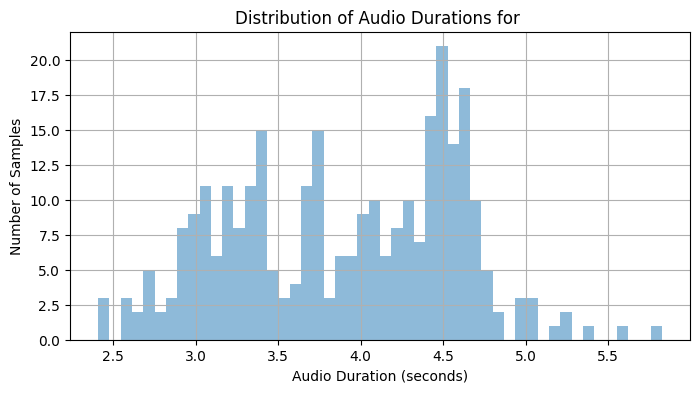

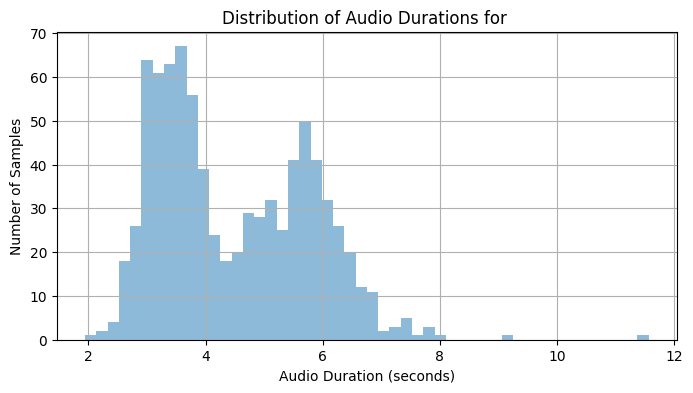

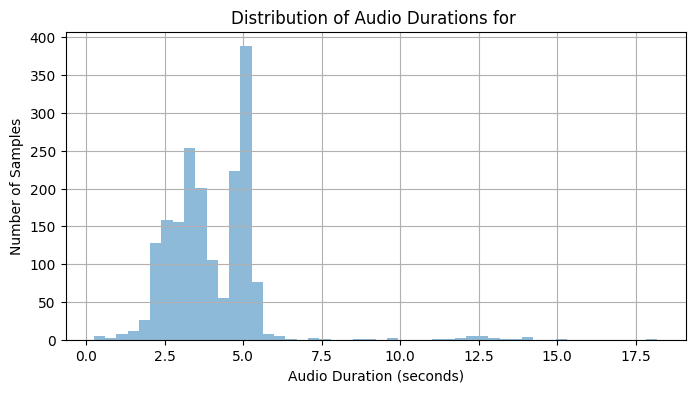

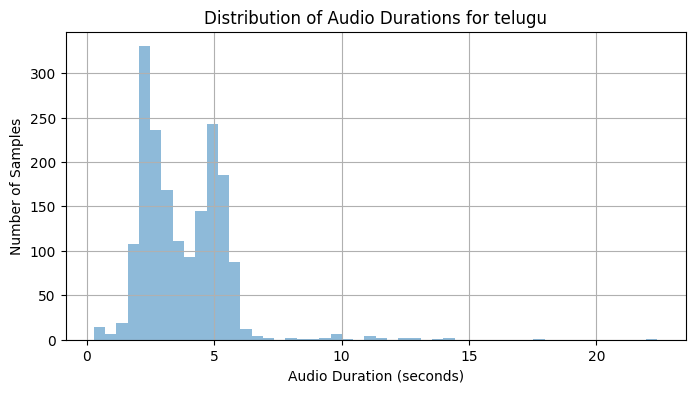

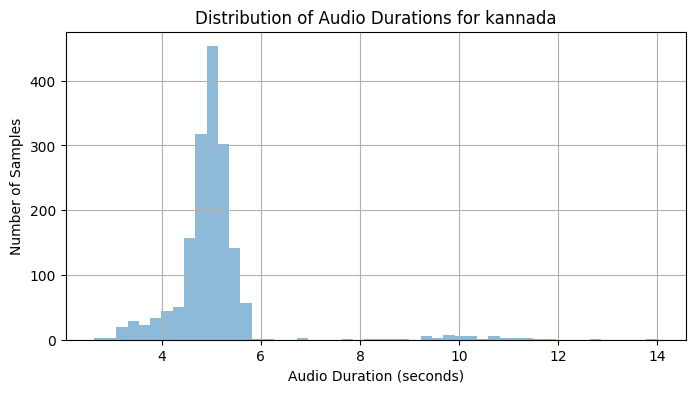

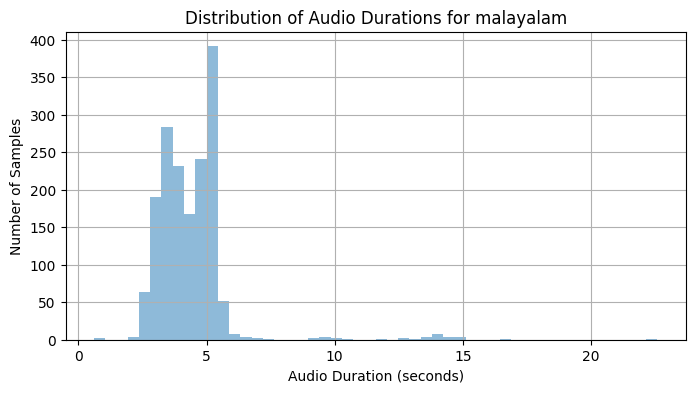

In [28]:
import librosa
import os
import matplotlib.pyplot as plt

language_dirs = [
    "/gujarati/",
    "/hindi/",
    "/tamil/",
    "/telugu",
    "/kannada",
    "/malayalam"
]


# Process each language's data
for lang_dir in language_dirs:
    language_name = os.path.basename(lang_dir)
    language_durations = []

    # Loop through audio files in the language directory
    for root, _, files in os.walk(lang_dir):
        for file in files:
            file_path = os.path.join(root, file)

            # Load audio file and calculate its duration
            y, sr = librosa.load(file_path)
            duration = librosa.get_duration(y=y, sr=sr)
            language_durations.append(duration)

    # Plot histogram of audio durations for this language
    plt.figure(figsize=(8, 4))
    plt.hist(language_durations, bins=50, alpha=0.5)
    plt.xlabel("Audio Duration (seconds)")
    plt.ylabel("Number of Samples")
    plt.title(f"Distribution of Audio Durations for {language_name}")
    plt.grid(True)
    plt.show()

# Data Creation
## Preprocess according to whisper specifications

In [ ]:
import glob
import os

In [2]:
train_path = glob.glob("/indic_mixed_train/*")
test_path = glob.glob("/indic_mixed_test/*")
validation_path = glob.glob("/indic_mixed_valid/*")

train = set()
for f in train_path:
    train.add(f.split("/")[-1].split("_")[0])

test = set()
for i in test_path:
    test.add(i.split("/")[-1].split("_")[0])
    
valid = set()
for i in validation_path:
    valid.add(i.split("/")[-1].split("_")[0])

In [3]:
train

{'Andhra', 'Gujrat', 'Jharkhand', 'Karnataka', 'Kerala', 'Tamil'}

In [4]:
test

{'Andhra', 'Gujrat', 'Jharkhand', 'Karnataka', 'Kerala', 'Tamil'}

In [5]:
valid

{'Andhra', 'Gujrat', 'Jharkhand', 'Karnataka', 'Kerala', 'Tamil'}

In [6]:
import os
import glob
from datasets import Dataset
from datasets import ClassLabel
from datasets import Audio
from datasets import DatasetDict

In [7]:
# fucntiuon to get the labelname from the filename
def extract_language_label(file_name):
    splits = file_name.split('_')
    return splits[0]  # e.g "Kerala_speaker_01_2_17.wav" ----> returns "Kerala" 

In [8]:
label = extract_language_label("Kerala_speaker_01_2_17.wav")
print(label)

Kerala


In [9]:
# Define the paths to your train and test directories containing audio files
train_dir = '/indic_mixed_train/'
test_dir = '/indic_mixed_test/'
valid_dir = '/indic_mixed_valid/'

# Create a mapping between language names and numerical labels
language_mapping = {
    "Tamil": 0,
    "Kerala": 1,
    "Gujrat": 2,
    "Andhra": 3,
    "Jharkhand": 4,
    "Karnataka": 5
}

# Create empty data dictionaries for train, test and valid
data_dict_train = {
    "audio": [],
    "label": [],
}

data_dict_test = {
    "audio": [],
    "label": [],
}

data_dict_valid = {
    "audio": [],
    "label": [],
}

# Process the train directory
for file_name in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file_name)
    language_label = extract_language_label(file_name)
    if language_label in language_mapping:
        data_dict_train["audio"].append(file_path)
        data_dict_train["label"].append(language_mapping[language_label])

# Process the test directory
for file_name in os.listdir(test_dir):
    file_path = os.path.join(test_dir, file_name)
    language_label = extract_language_label(file_name)
    if language_label in language_mapping:
        data_dict_test["audio"].append(file_path)
        data_dict_test["label"].append(language_mapping[language_label])

# Process the validation directory
for file_name in os.listdir(valid_dir):
    file_path = os.path.join(valid_dir, file_name)
    language_label = extract_language_label(file_name)
    if language_label in language_mapping:
        data_dict_valid["audio"].append(file_path)
        data_dict_valid["label"].append(language_mapping[language_label])

# Create a labels object
labels = ClassLabel(num_classes=len(language_mapping), names=list(language_mapping.keys()))

# Create datasets
train = Dataset.from_dict(data_dict_train)
test = Dataset.from_dict(data_dict_test)
valid = Dataset.from_dict(data_dict_valid)

# Create a DatasetDict
speech = DatasetDict({
    "train": train,
    "test": test,
    "valid": valid,
})

# Cast columns
speech = speech.cast_column("audio", Audio(sampling_rate=16000))
speech = speech.cast_column('label', labels)

Casting the dataset:   0%|          | 0/2382 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3940 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1594 [00:00<?, ? examples/s]

In [10]:
speech

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 2382
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 3940
    })
    valid: Dataset({
        features: ['audio', 'label'],
        num_rows: 1594
    })
})

In [11]:
from transformers import AutoProcessor, AutoModelForAudioClassification

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [12]:
# Select CUDA device index
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model_name_or_path = "openai/whisper-small"

# load the processor
processor = AutoProcessor.from_pretrained(model_name_or_path)

In [13]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt" ).input_features[0]

    # encode target text to label ids
    batch["label"] = batch["label"]

    return batch

In [14]:
# remove audio column from dataset since input_features is already there
dataset = speech.map(prepare_dataset, remove_columns=["audio"], num_proc=1)
dataset

Map:   0%|          | 0/2382 [00:00<?, ? examples/s]

Map:   0%|          | 0/3940 [00:00<?, ? examples/s]

Map:   0%|          | 0/1594 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_features'],
        num_rows: 2382
    })
    test: Dataset({
        features: ['label', 'input_features'],
        num_rows: 3940
    })
    valid: Dataset({
        features: ['label', 'input_features'],
        num_rows: 1594
    })
})

In [15]:
from huggingface_hub import login

In [16]:
# create and add hugging face token to upload data
use_auth_token = ''
login(use_auth_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful


In [17]:
dataset.push_to_hub("Username/Datasetname") # replace the user name and the dataset name

Pushing dataset shards to the dataset hub:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/8 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

# loading and checking the data

In [19]:
from datasets import load_dataset
data = load_dataset("Username/Datasetname") #  replace the user name and the dataset name

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2382 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3940 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1594 [00:00<?, ? examples/s]